In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_size = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30
n_classes = 3

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True, #Randomly shuffle the images and load them ->Desirable during training because it helps prevent the model from learning patterns based on the order of the data
    image_size = (IMAGE_size,IMAGE_size),
    batch_size = BATCH_SIZE 
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 0 1 2 2 0 2 2 1 0 2 1 1 0 0 2 0 0 0 1 1 0 1 1 1 1 1 1]


In [9]:
 for image_batch, label_batch in dataset.take(1):
        print(image_batch[0].shape)

(256, 256, 3)


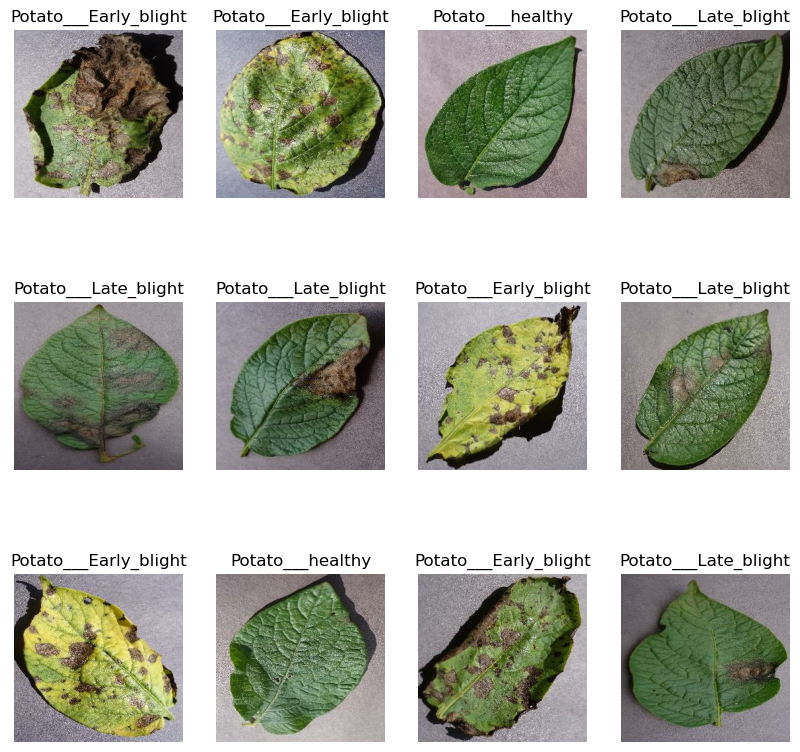

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
        for i in range(12) :
            ax = plt.subplot(3,4,i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label_batch[i]])
            plt.axis("off")

In [11]:
train_size = 0.8
val_size = 0.1
test_size=0.1

In [12]:
len(dataset)*train_size

54.400000000000006

In [13]:
train_dataset = dataset.take(54) #similar to arr[:54]

In [14]:
test_dataset = dataset.skip(54) #s=similar to arr[54:]
len(test_dataset)

14

In [15]:
len(dataset)*val_size

6.800000000000001

In [16]:
val_dataset = test_dataset.take(6)

In [17]:
test_dataset = test_dataset.skip(6)

In [18]:
len(val_dataset)

6

In [19]:
len(test_dataset)

8

**Method 2**

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds,val_ds,test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)


54

In [23]:
len(val_ds)

6

In [24]:
len(test_ds)

8

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_size, IMAGE_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
 data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
 ])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_size, IMAGE_size, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), #Convolutional Layers
    layers.MaxPooling2D((2, 2)), #Pooling layer
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(),
    layers.Dense(64, activation='relu'), #Dense Layers
    layers.Dense(n_classes, activation='softmax')
])

In [29]:
model.build(input_shape = input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 83s 1s/step - loss: 0.9060 - accuracy: 0.4803 - val_loss: 0.8715 - val_accuracy: 0.4844
Epoch 2/30
54/54 [==============================] - 119s 2s/step - loss: 0.7552 - accuracy: 0.6319 - val_loss: 0.5993 - val_accuracy: 0.7448
Epoch 3/30
54/54 [==============================] - 140s 3s/step - loss: 0.4628 - accuracy: 0.8113 - val_loss: 0.4064 - val_accuracy: 0.8438
Epoch 4/30
54/54 [==============================] - 135s 3s/step - loss: 0.3229 - accuracy: 0.8681 - val_loss: 0.2647 - val_accuracy: 0.8906
Epoch 5/30
54/54 [==============================] - 134s 2s/step - loss: 0.2427 - accuracy: 0.9086 - val_loss: 0.5337 - val_accuracy: 0.8021
Epoch 6/30
54/54 [==============================] - 135s 3s/step - loss: 0.1660 - accuracy: 0.9369 - val_loss: 0.2188 - val_accuracy: 0.9323
Epoch 7/30
54/54 [==============================] - 137s 3s/step - loss: 0.2081 - accuracy: 0.9167 - val_loss: 0.0901 - val_accuracy: 0.9583
Epoch 8/30
54/

In [33]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 10s 565ms/step - loss: 0.2217 - accuracy: 0.9336


In [34]:
scores

[0.22174644470214844, 0.93359375]

In [35]:
 history 

In [36]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [38]:
history.history['accuracy']

[0.48032405972480774,
 0.6319444179534912,
 0.8113425970077515,
 0.8680555820465088,
 0.9085648059844971,
 0.9369212985038757,
 0.9166666865348816,
 0.9473379850387573,
 0.9571759104728699,
 0.9658564925193787,
 0.9751157164573669,
 0.9629629850387573,
 0.9826388955116272,
 0.9716435074806213,
 0.9675925970077515,
 0.9762731194496155,
 0.984375,
 0.9756944179534912,
 0.9872685074806213,
 0.9837962985038757,
 0.9814814925193787,
 0.9849537014961243,
 0.984375,
 0.9872685074806213,
 0.9791666865348816,
 0.9878472089767456,
 0.9866898059844971,
 0.9826388955116272,
 0.9861111044883728,
 0.9866898059844971]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

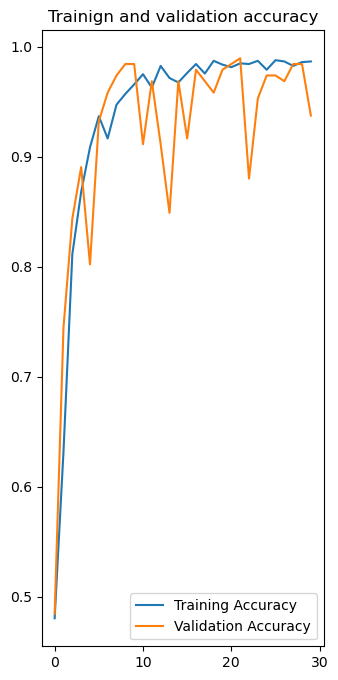

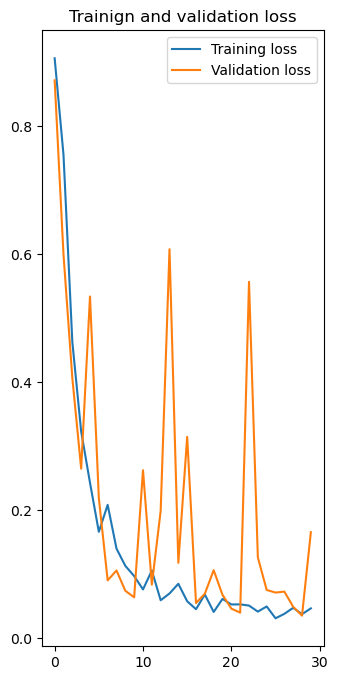

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Trainign and validation accuracy')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainign and validation loss')
plt.show()

1/1 [==============================] - 0s 73ms/step


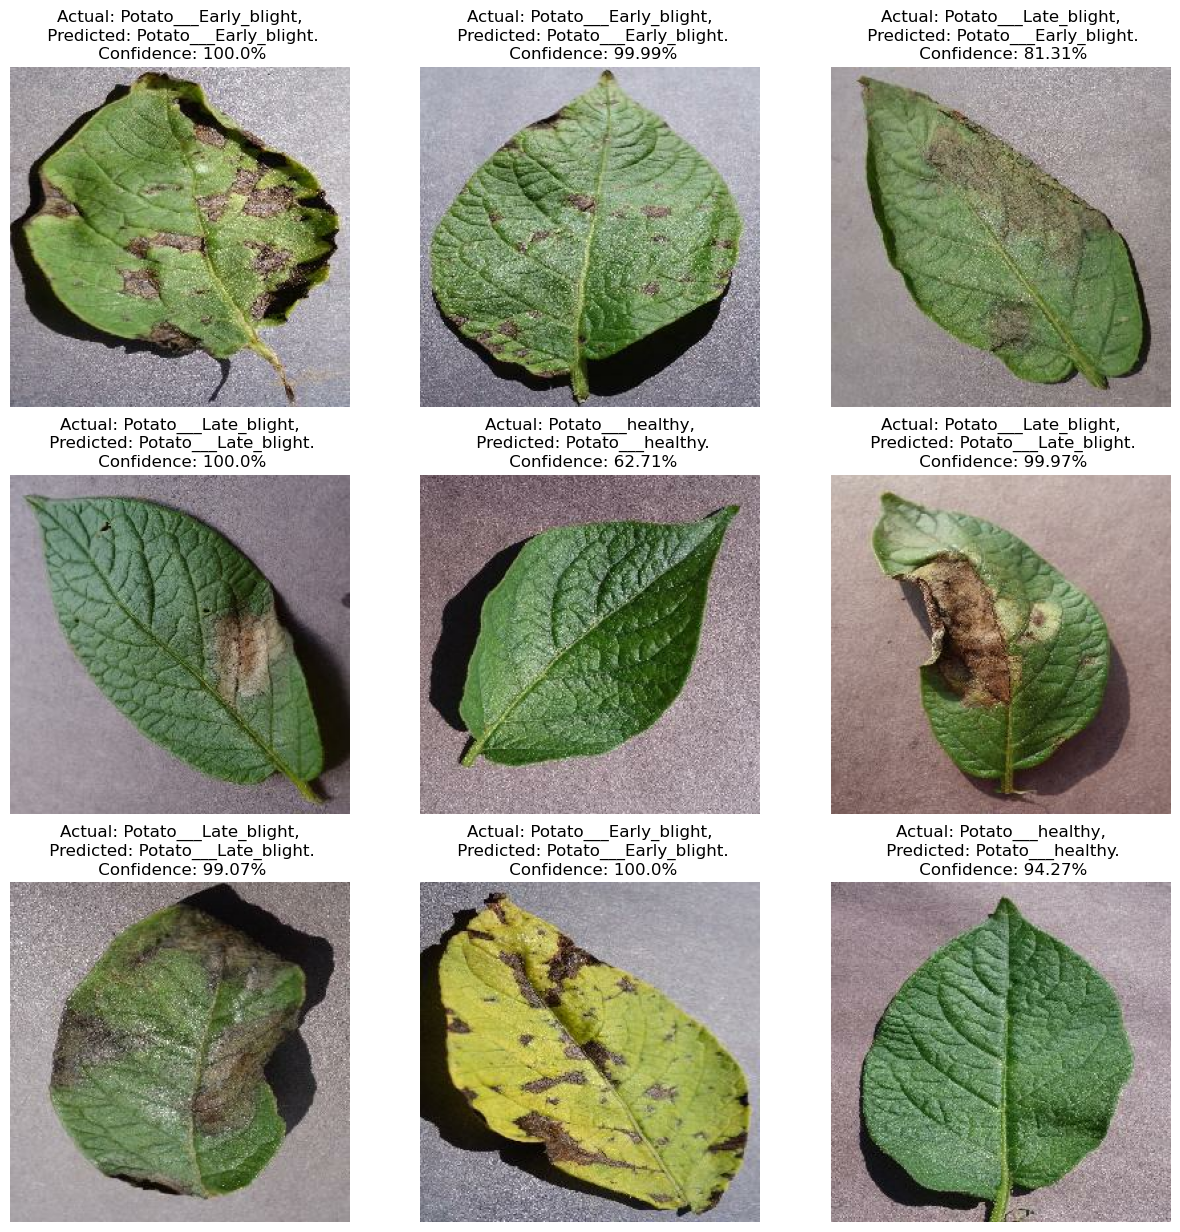

In [47]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [49]:
model_version=1

In [50]:
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [51]:
import os
model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
model.save(f"../models/{model_version}") #to auto increment the new model version

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [30]:
loaded_model = tf.keras.models.load_model("../models/1")

In [31]:
loaded_model

In [33]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 59ms/step


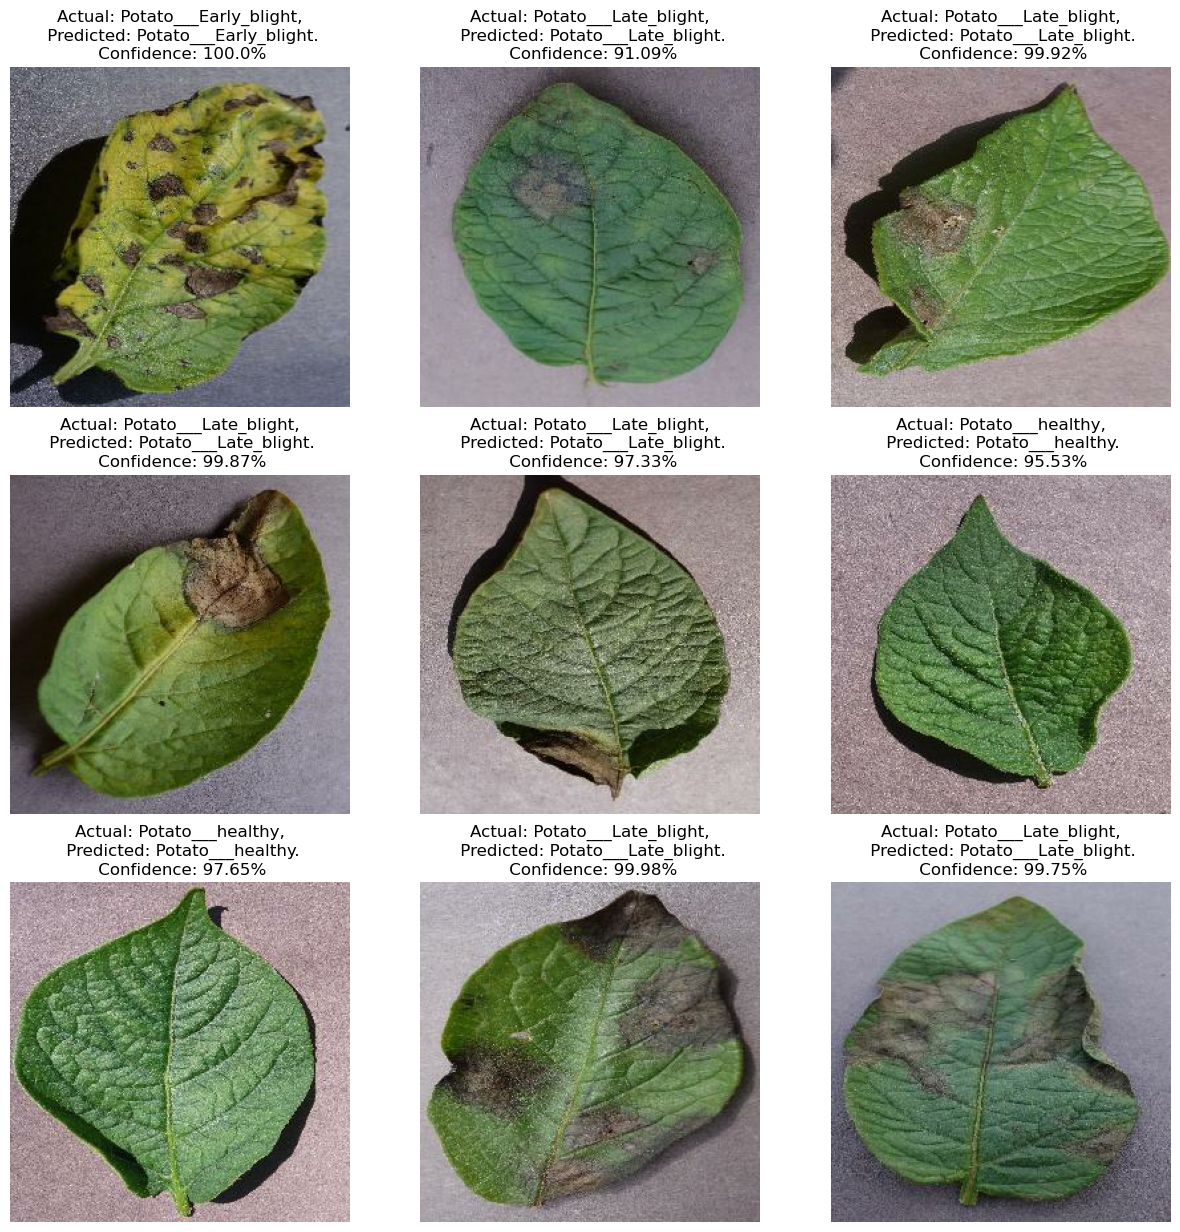

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(loaded_model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")